## Importing the Libraries and Dataset

In [1]:
import pandas as pd
import numpy as np
import random
import seaborn as sn
import matplotlib.pyplot as plt

dataset = pd.read_csv('new_churn_data.csv')

## Data Preparation and Preprocessing

In [2]:
# Store and then remove user column since we do not need it right now
user_identifier = dataset['user']
dataset = dataset.drop(columns = ['user'])

In [3]:
# One-Hot Encoding

# Gets us the value count of each label in housing
dataset.housing.value_counts()
dataset.groupby('housing')['churn'].nunique().reset_index()
# Finds the categorical variables and sets them up as their own binary columns
dataset = pd.get_dummies(dataset)
dataset.columns
# Need to drop 1 column of the categorical variables in order to avoid the dummy variable trap 
# housing_na will be 0 if the others are 1 so it is not needed; same process for the others
dataset = dataset.drop(columns = ['housing_na', 'zodiac_sign_na', 'payment_type_na'])

In [4]:
# Splitting the dataset into the Training set and Test set
# 80:20 Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset.drop(columns = 'churn'), dataset['churn'],
                                                    test_size = 0.2,
                                                    random_state = 0)

## Balance the Training Set

In [5]:
# Balancing the Training Set so that there are the same amount of 1's and 0's to avoid a model that only picks 0 
# and still gets an accuracy of around 60 percent

# Get the distributions of the training data; about 4,000 not churn then churned so we need to balance the data
y_train.value_counts()

pos_index = y_train[y_train.values == 1].index
neg_index = y_train[y_train.values == 0].index

# If there are more positive values than 0 values
if len(pos_index) > len(neg_index):
    # Make positive higher and negative lower values
    higher = pos_index
    lower = neg_index
else:
    # Make negative values higher and positive values lower
    higher = neg_index
    lower = pos_index

# Set a seed of 0 so we can dupliate the results
random.seed(0)
# Randomly select random indexes of the higher set so that it is the same size as the lower 
higher = np.random.choice(higher, size=len(lower))
# Make lower a numpy array so that is the same format as higher
lower = np.asarray(lower)
# Get the new indexes as a combination of lower and higher indexes which are now the same size
new_indexes = np.concatenate((lower, higher))

# Add the new_indexes combination to the X_train and y_train so that we have balanced data
X_train = X_train.loc[new_indexes,]
y_train = y_train[new_indexes]

In [6]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
# Create a standard scaler object
sc_X = StandardScaler()
# Create a new training set that is a transformed version of X_train
X_train2 = pd.DataFrame(sc_X.fit_transform(X_train))
# Create a new test set that is a transformed version of X_test
X_test2 = pd.DataFrame(sc_X.transform(X_test))
# Extract the column names from train and test dataframes
X_train2.columns = X_train.columns.values
X_test2.columns = X_test.columns.values
# Extract the index values from both the training and test sets
X_train2.index = X_train.index.values
X_test2.index = X_test.index.values
# Replace the original training and test sets to our new training and test sets
X_train = X_train2
X_test = X_test2

## Model Building

In [7]:
# Fitting Model to the Training Set
from sklearn.linear_model import LogisticRegression
# Create a Logistic Regression object with a random state of 0 so we can duplicate the results
classifier = LogisticRegression(random_state = 0)
# Fit the model to the Training Data
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [8]:
# Predicting Test Set
y_pred = classifier.predict(X_test)

## Evaluating Results

In [9]:
# Get the accuracy
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
accuracy_score(y_test, y_pred)

0.6417084102293699

In [10]:
# Compute the Precision; of all the predicted positives how many are true
precision_score(y_test, y_pred) # tp / (tp + fp)

0.5476738830032243

In [11]:
# Compute the Recall; of all the positives how many are actually true
recall_score(y_test, y_pred) # tp / (tp + fn)

0.7592592592592593

In [12]:
# Get the f1_score; a function of precision and recall and it balances the scores 
f1_score(y_test, y_pred)

0.6363393096066364

Test Data Accuracy: 0.6417


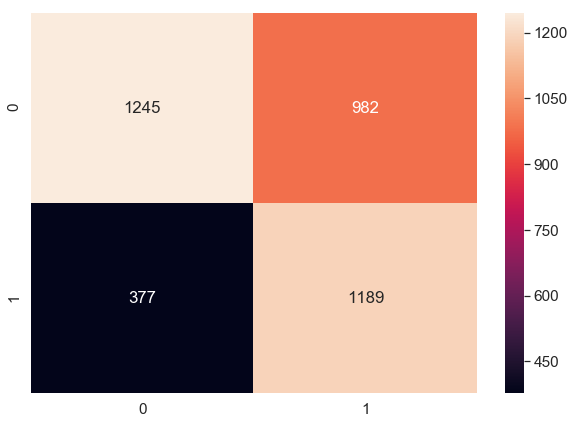

In [13]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, fmt='g')
print("Test Data Accuracy: %0.4f" % accuracy_score(y_test, y_pred))

Results: True Positives:1245; False Negatives:1189; Type 1 Errors (Predicted yes but actually no):982; Type 2 Errors (Predicted no but actually yes):377

In [14]:
# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
# Create the accuracies
"""Parameters: Estimator-our model
               X-use our X_train data as feature data
               y-use our y_train as our dependent variable
               cv-use 10 folds"""
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
# This means that the 64% accuracy is consistent across all parts of the dataset
print("SVM Accuracy: %0.3f (+/- %0.3f)" % (accuracies.mean(), accuracies.std() * 2))

SVM Accuracy: 0.652 (+/- 0.020)


In [15]:
# Analyzing Coefficients
# First column is the columns of the X_train with a title of features
# Second column is the coefficients of the model with a title of coef
#axis=1 so we get columns not rows 
pd.concat([pd.DataFrame(X_train.columns, columns = ["features"]),
           pd.DataFrame(np.transpose(classifier.coef_), columns = ["coef"])
           ],axis = 1)

,features,coef
0,age,-0.177493
1,deposits,0.192067
2,withdrawal,0.021345
3,purchases_partners,-0.732820
4,purchases,-0.336918
5,cc_taken,0.033162
6,cc_recommended,-0.004873
7,cc_disliked,-0.008802
8,cc_liked,-0.003730
9,cc_application_begin,0.039825


## Feature Selection 

In [16]:
# Recursive Feature Elimination
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Model to Test
classifier = LogisticRegression()
# Select Best X Features
# We want 20 columns from RFE
rfe = RFE(classifier, 20)
# Fit the training data to the RFE object
rfe = rfe.fit(X_train, y_train)
# summarize the selection of the attributes

# Shows True if the column is in the final result; False other wise
print(rfe.support_)
# This shows the rankings of the importance of the columns
print(rfe.ranking_)
# These are the actual columns that are used in the model
X_train.columns[rfe.support_]

[ True  True False  True  True False False False False  True  True  True
  True  True  True False  True  True  True False  True  True False False
  True  True  True  True False  True False False False False False False
 False False False False False]
[ 1  1  7  1  1  4 18 16 21  1  1  1  1  1  1 10  1  1  1 14  1  1  8 11
  1  1  1  1  3  1 15 20 12 19 22 13  2 17  6  5  9]


Index(['age', 'deposits', 'purchases_partners', 'purchases',
       'cc_application_begin', 'app_downloaded', 'web_user', 'ios_user',
       'android_user', 'registered_phones', 'cancelled_loan', 'received_loan',
       'rejected_loan', 'left_for_one_month', 'reward_rate', 'housing_R',
       'payment_type_Bi-Weekly', 'payment_type_Monthly',
       'payment_type_Semi-Monthly', 'zodiac_sign_Aquarius'],
      dtype='object')

## New Correlation Matrix

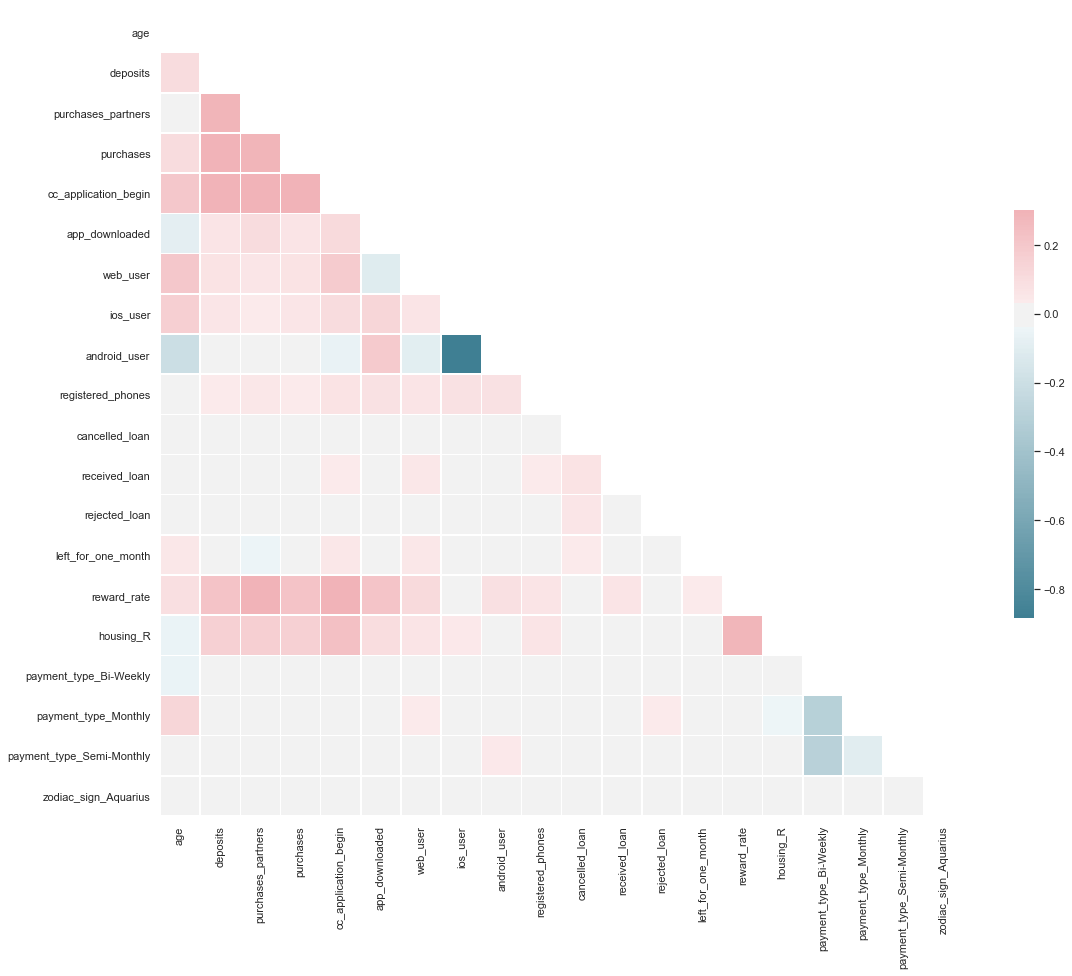

In [17]:
# New Correlation Matrix
sn.set(style="white")

# Compute the correlation matrix on the rfe.support columns; we are only using the most useful columns
corr = X_train[X_train.columns[rfe.support_]].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 15))

# Generate a custom diverging colormap
cmap = sn.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sn.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}) 

## Tuning the Model

In [18]:
# Fitting Model to the Training Set
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
# Fit the model to only the important columns
classifier.fit(X_train[X_train.columns[rfe.support_]], y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [19]:
# Predicting Test Set with the important columns
y_pred = classifier.predict(X_test[X_train.columns[rfe.support_]])

## Evaluating Results

The metrics are about the same even though we are only using 20 columns. This means that many of the columns are irrlevant to the model. This allows our model to be less computationally expensive and just as effective

In [20]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
# Compute the accuracy
accuracy_score(y_test, y_pred)

0.6403901924597943

In [21]:
# Compute the precision
precision_score(y_test, y_pred) # tp / (tp + fp)

0.546203110704483

In [22]:
# Compute the recall
recall_score(y_test, y_pred) # tp / (tp + fn)

0.7624521072796935

In [23]:
# Compute the f1_score
f1_score(y_test, y_pred)

0.6364605543710021

Test Data Accuracy: 0.6404


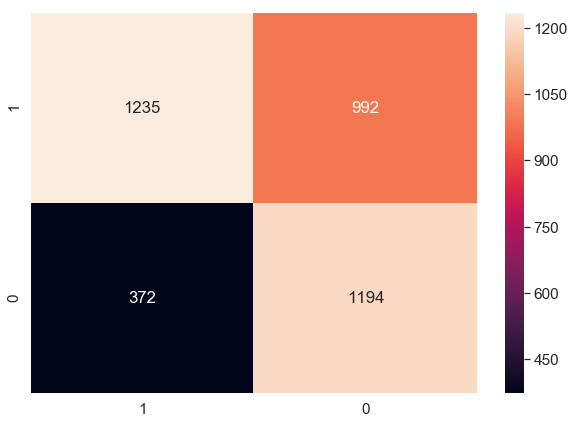

In [24]:
# Create the confusion Matix
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index = (1, 0), columns = (1, 0))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, fmt='g')
print("Test Data Accuracy: %0.4f" % accuracy_score(y_test, y_pred))

In [25]:
# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier,
                             X = X_train[X_train.columns[rfe.support_]],
                             y = y_train, cv = 10)
print("SVM Accuracy: %0.3f (+/- %0.3f)" % (accuracies.mean(), accuracies.std() * 2))

SVM Accuracy: 0.648 (+/- 0.020)


In [26]:
# Analyzing Coefficients
pd.concat([pd.DataFrame(X_train[X_train.columns[rfe.support_]].columns, columns = ["features"]),
           pd.DataFrame(np.transpose(classifier.coef_), columns = ["coef"])
           ],axis = 1)

,features,coef
0,age,-0.177591
1,deposits,0.190114
2,purchases_partners,-0.733005
3,purchases,-0.327803
4,cc_application_begin,0.049008
5,app_downloaded,-0.049819
6,web_user,0.143141
7,ios_user,0.120107
8,android_user,0.041399
9,registered_phones,0.081333


## Formatting Final Results

In [28]:
# Combine the actual result with the identifier for the user with an axis of 1 so they are columns; get rid of nan values
final_results = pd.concat([y_test, user_identifier], axis = 1).dropna()
# Create a new column with the our predicted values
final_results['predicted_churn'] = y_pred
# Reorder to the columns so that it is easy to view; reset the indexes since we no longer care about indexes
final_results = final_results[['user', 'churn', 'predicted_churn']].reset_index(drop=True)
final_results

,user,churn,predicted_churn
0,20839,0.0,1
1,15359,1.0,0
2,34210,1.0,0
3,57608,1.0,1
4,11790,0.0,0
5,1826,1.0,1
6,8508,0.0,1
7,50946,1.0,1
8,50130,1.0,0
9,55422,0.0,1
